# Zillow Regression Project 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pydataset import data

import wrangle as w
import explore as ex
import evaluate as ev


from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

In [3]:
# set continous palette 
z_contpalette = ['#c3eafb', '#74acfc', '#5289e4', '#448cfc', '#126cfa']

# I think you can also do a colormap between two colors as well

In [4]:
sns.color_palette(z_contpalette)

[(0.7647058823529411, 0.9176470588235294, 0.984313725490196),
 (0.4549019607843137, 0.6745098039215687, 0.9882352941176471),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.26666666666666666, 0.5490196078431373, 0.9882352941176471),
 (0.07058823529411765, 0.4235294117647059, 0.9803921568627451)]

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Acquire / Prepare
#### Goals
- get data 
- look at and deal with nulls and duplicates
- understand what I'm looking at

In [5]:
# get data using sql query and wrangle function

df = w.get_zillow_data()

In [6]:
# take a peak at data
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,6037.0,1399.27,2017-08-23


In [7]:
# look at column info see if there's anything need to change as far as types
# can see some nulls
# need to change date to a datetime object 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         28124 non-null  int64  
 1   tax_value         28123 non-null  float64
 2   bathroom_cnt      28124 non-null  float64
 3   bedroom_cnt       28124 non-null  float64
 4   sqft_calculated   28077 non-null  float64
 5   fips              28124 non-null  float64
 6   tax_amount        28123 non-null  float64
 7   transaction_date  28124 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 1.9+ MB


In [42]:
# change transaction_date to datetime object
# line is in wrangle.py
df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [43]:
df.transaction_date.dtypes

dtype('<M8[ns]')

In [8]:
df.duplicated().value_counts()

False    28124
dtype: int64

In [9]:
w.missing_values_table(df)

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
sqft_calculated,47,0.2
tax_value,1,0.0
tax_amount,1,0.0


#### Takeaways Nulls / Dupes
- There are no duplicates! 
- Not too many missing values. Will probably drop them. But will take a look at the columns individually
- 47 sqft missing - DROP
- 1 tax_value - DROP
- 1 tax_amount DROP (thought about keeping it just for modeling and throwing it out for county tax info but it's just 1 row)

In [10]:
# look at rows that have NaNs
df[df.isna().any(axis=1)]

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
54,14430658,5346951.0,0.0,0.0,NaN,6059.0,82484.04,2017-08-25
325,14466991,2493444.0,0.0,0.0,NaN,6059.0,25740.28,2017-05-01
968,13972530,270009.0,0.0,0.0,NaN,6059.0,3230.88,2017-05-04
969,14325627,7074075.0,0.0,0.0,NaN,6059.0,81640.56,2017-05-04
988,12686981,5461875.0,0.0,0.0,NaN,6037.0,60905.26,2017-05-04
2679,12131538,225126.0,0.0,0.0,NaN,6037.0,2736.14,2017-05-11
4148,17292027,3210155.0,0.0,0.0,NaN,6111.0,34159.22,2017-05-18
5232,12920381,352000.0,2.0,3.0,944.0,6037.0,NaN,2017-05-24
5605,14430787,5126781.0,0.0,0.0,NaN,6059.0,80251.50,2017-05-25
6637,17267536,26237.0,0.0,0.0,NaN,6111.0,302.94,2017-05-30


In [11]:
total_rows = df.shape[0] 
rows_with_nans =  df[df.isna().any(axis=1)].shape[0]

print(f'There are {total_rows} total rows, {rows_with_nans} of which have NaN values.')
print(f'If we drop the rows with NaNs there should be {total_rows-rows_with_nans} rows left')
print(f'It\'s {rows_with_nans/total_rows:.2%} of the data')

There are 28124 total rows, 49 of which have NaN values.
If we drop the rows with NaNs there should be 28075 rows left
It's 0.17% of the data


In [12]:
# Check to make sure numbers match up
df.drop(df[df.isna().any(axis=1)].index).shape

(28075, 8)

In [13]:
#drop the rows 
df.drop(df[df.isna().any(axis=1)].index, inplace=True)

In [14]:
# check to make sure it worked
df.shape

(28075, 8)

In [15]:
# look at unique values in each column
for col in df.drop(columns=['parcel_id', 'tax_value', 'tax_amount']).columns:
    print(f'---------------')
    print(f'There are {df[col].nunique()} unique values in the {col} column')

---------------
There are 20 unique values in the bathroom_cnt column
---------------
There are 13 unique values in the bedroom_cnt column
---------------
There are 4055 unique values in the sqft_calculated column
---------------
There are 3 unique values in the fips column
---------------
There are 119 unique values in the transaction_date column


In [16]:
# single family homes are sometimes defined as houses that don't have more than 5 bedrooms
# filter to see how many we have above that
(df['bedroom_cnt']  > 5).value_counts()

False    27668
True       407
Name: bedroom_cnt, dtype: int64

In [17]:
df.bedroom_cnt.value_counts()

3.0     12551
4.0      8287
2.0      4348
5.0      2141
6.0       340
1.0       311
7.0        50
0.0        30
8.0         7
9.0         4
12.0        3
10.0        2
11.0        1
Name: bedroom_cnt, dtype: int64

#### Homes with more than 5 bedrooms
- there are 407 homes with MORE than 5 bedrooms
- won't get rid of them now but might be a good place to get rid of outliers

Also saw here there are columns with 0 bed rooms need to get rid of those

In [18]:
df[df.bedroom_cnt == 0].head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
8,11696784,168828.0,0.0,0.0,1378.0,6037.0,2135.39,2017-06-16
231,11787436,188000.0,1.0,0.0,740.0,6037.0,2399.69,2017-05-01
253,11392193,101792.0,0.0,0.0,2276.0,6037.0,1609.95,2017-05-01
338,11266326,49627.0,0.0,0.0,400.0,6037.0,703.30,2017-05-01
793,11938527,319396.0,0.0,0.0,389.0,6037.0,4059.62,2017-05-03


#### 1 bathroom and 0 bedrooms with sqftage might be a studio! I will keep those in

#### 0 Bathroom and 0 (or any number of) bedrooms with sqftage will be dropped. can't guess how many beds and bathrooms those have

In [19]:
total_rows = df.shape[0] 
rows_with =  df[df.bathroom_cnt == 0].shape[0]

print(f'There are {total_rows} total rows, {rows_with} with 0 in the bathroom_cnt column.')
print(f'If we drop these rows there should be {total_rows-rows_with} rows left')
print(f'It\'s {rows_with_nans/total_rows:.2%} of the data')

There are 28075 total rows, 23 with 0 in the bathroom_cnt column.
If we drop these rows there should be 28052 rows left
It's 0.17% of the data


In [20]:
# drop the rows with the 0 bathroom count
df.drop(df[df.bathroom_cnt == 0].index, inplace=True)

In [21]:
df.shape

(28052, 8)

### Target
- tax_value

### Variables 
#### Categorial variables:
- fips
- bedrooms
- bathrooms 

#### Continous variables:
- sqft_calculated
- transaction_date 

#### Other
- parcel_id - unique identifer
- tax_amount - not used for modeling


In [109]:
# final test with wrangle.py function

df = w.wrangle_zillow()

In [102]:
# it worked, it has the correct shape

df.shape

(28052, 8)

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore 
#### Goals 
- Univariate exploration 
    - find and deal with outliers
- train, validate, test split
- Multivariate exploration
- Vizualize relationship between variables and target
- Find Drivers
- State Hypotheses and run some Statistical Tests


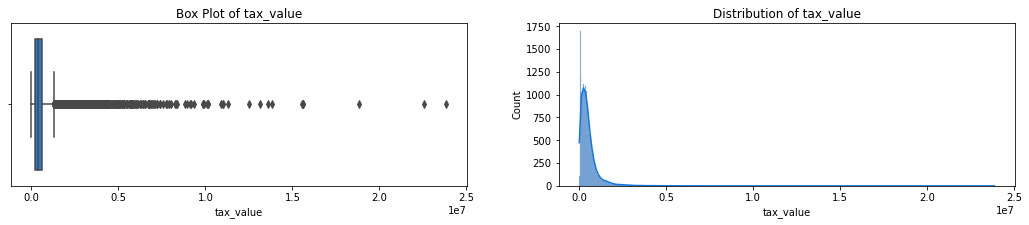

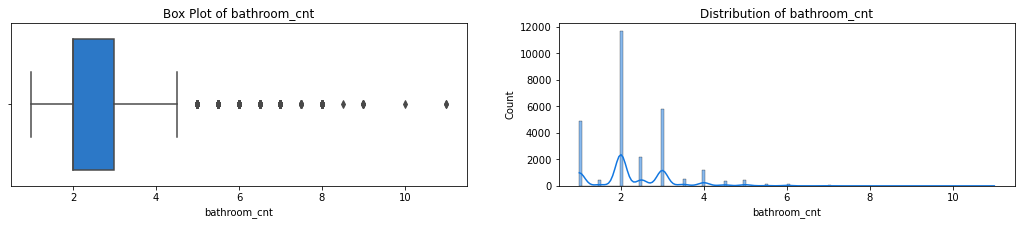

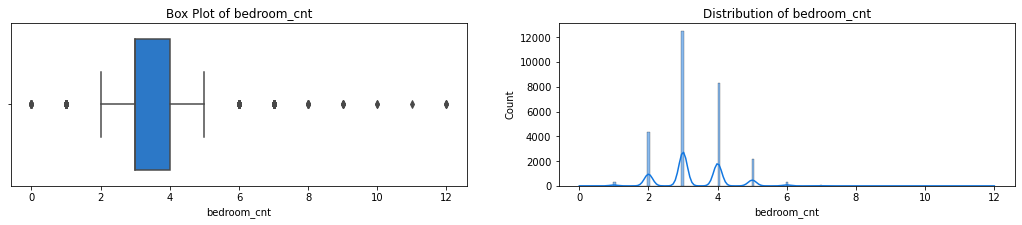

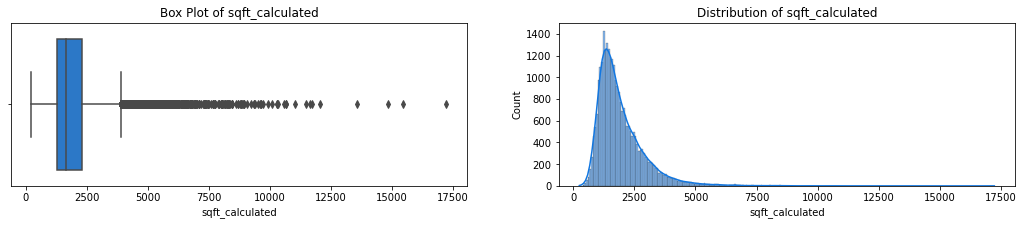

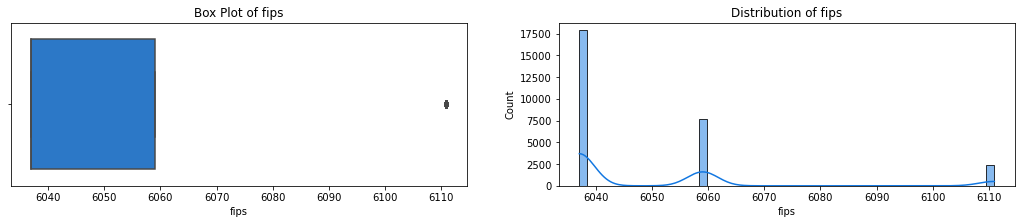

In [79]:
# use function from explore to look at distributions
ex.explore_univariate(df.drop(columns=['parcel_id', 'transaction_date', 'tax_amount']))

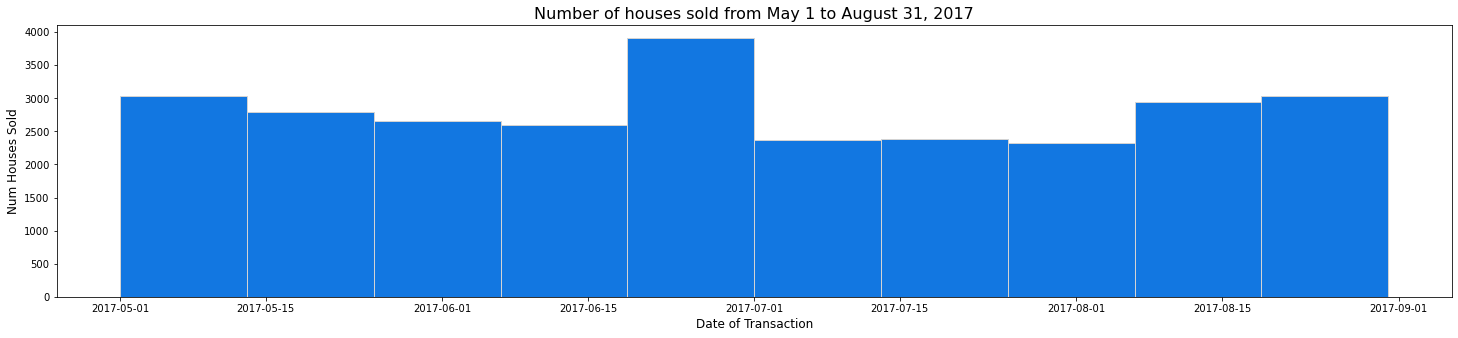

In [65]:
# plot dates houses were sold
plt.figure(figsize=(25, 5))
plt.hist(df.transaction_date, lw = 1, ec = 'lightgrey')
plt.xlabel('Date of Transaction', fontsize = 12)
plt.ylabel('Num Houses Sold', fontsize = 12)
plt.title('Number of houses sold from May 1 to August 31, 2017', fontsize = 16)
plt.show()

### Takeaways
- Need to drop outliers
- most of the houses are in LA county (fips 6037)
- The second half of June 2017 saw higher number of house sales

In [66]:
# add to wrangle function
import scipy.stats as stats

def remove_outlier(df):
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df

In [104]:
df_new = remove_outlier(df[['sqft_calculated', 'bedroom_cnt', 'bathroom_cnt']])

In [90]:
df.shape[0] - df_new.shape[0]
print(f'{df.shape[0] - df_new.shape[0]} rows dropped')

641 rows dropped


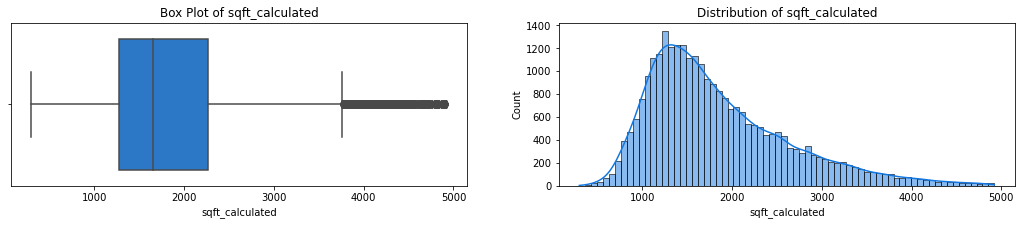

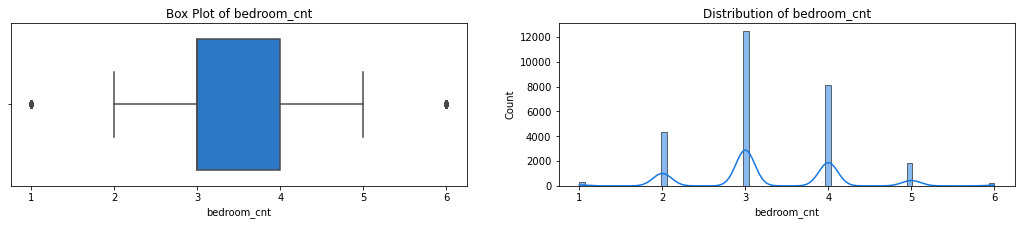

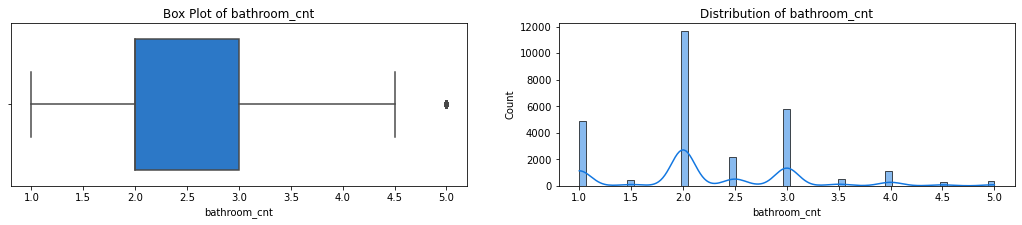

In [76]:
ex.explore_univariate(df_new)

In [122]:
# remove outliers from real dataframe
remove_outlier(df[['sqft_calculated', 'bedroom_cnt', 'bathroom_cnt']]).index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     9,
               10,
            ...
            28114, 28115, 28116, 28117, 28118, 28119, 28120, 28121, 28122,
            28123],
           dtype='int64', length=27411)

In [127]:
# create index from removed outliers to remove all rows with outliers
df.index.isin(df_new.index)

array([ True,  True,  True, ...,  True,  True,  True])

In [130]:
# add to wrangle function
df = df[df.index.isin(df_new.index)]

In [132]:
# good 641 rows were dropped
df.shape

(27411, 8)

### Takeaways
- After dropping outliers still a lot of outliers to deal with in sqft_calculated. will come back and deal with them later
- Makes sense though. Lots of really expensive houses in LA, Orange County, and Ventura County
- Maybe deal with outliers by scaling the data
- Still outliers in target. 15,618,488.00 is max tax value (dang california)

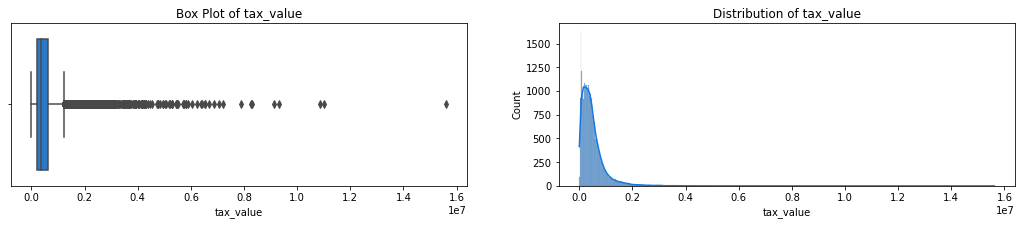

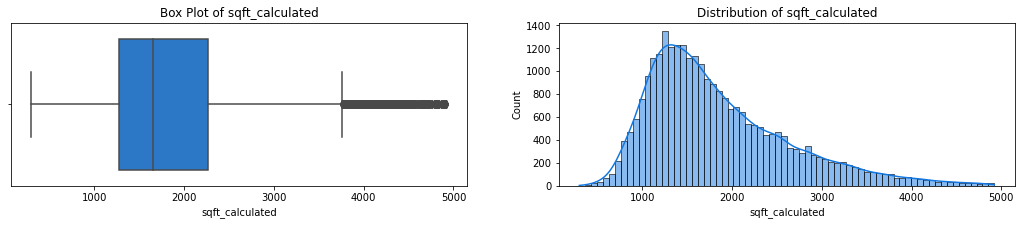

In [136]:
ex.explore_univariate(df[['tax_value', 'sqft_calculated']])

In [138]:
df.tax_value.max()

15618488.0

### Split and Bivarate Exploration

In [19]:
df = w.wrangle_zillow()

In [20]:
# drop columns I don't need for exploration
df = df.drop(columns=['parcel_id', 'fips', 'tax_amount', 'transaction_date'])

In [21]:
df.shape

(27411, 4)

In [22]:
# split the data
train, validate, test = w.banana_split(df)

train --> (15349, 4)
validate --> (6579, 4)
test --> (5483, 4)


In [23]:
train.columns

Index(['tax_value', 'bathroom_cnt', 'bedroom_cnt', 'sqft_calculated'], dtype='object')

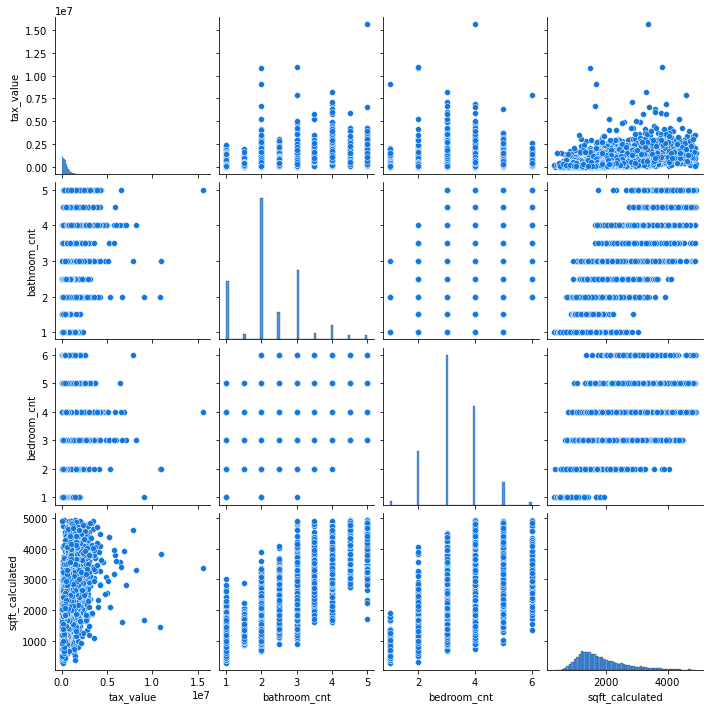

In [24]:
sns.pairplot(train)

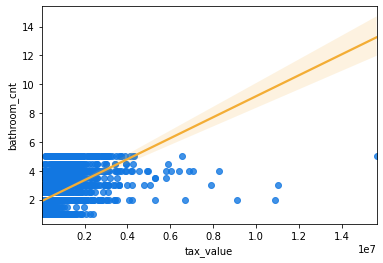

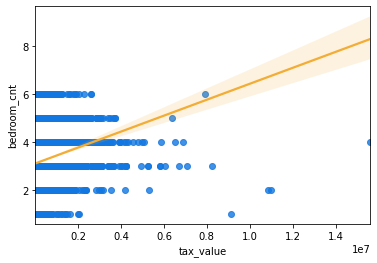

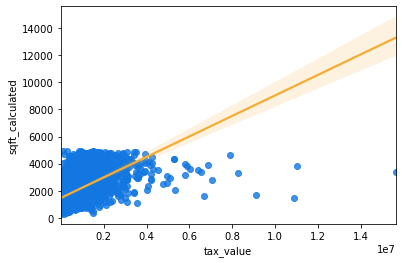

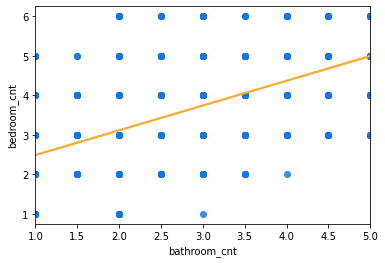

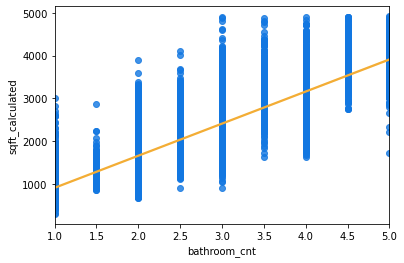

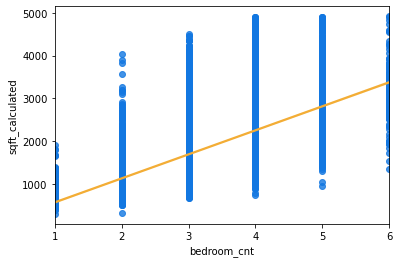

In [25]:
ex.plot_variable_pairs(train, list(train), dot_color='#1277e1', line_color=  '#f3ad35')

#### Takeaways
- As I suspected the bigger the house the bigger the cost
- more bedrooms a place have the more bathrooms it has as well

In [26]:
# use minmax scaler on sqft_calculated 
scaler, scaled_cols = w.my_scaler(train, validate, test, ['sqft_calculated'], MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


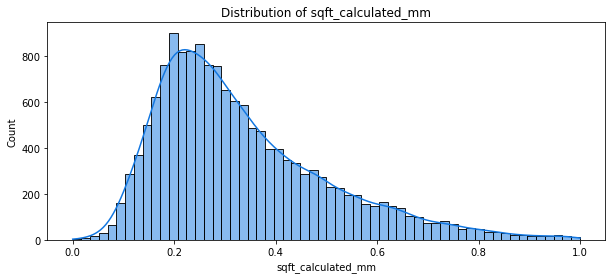

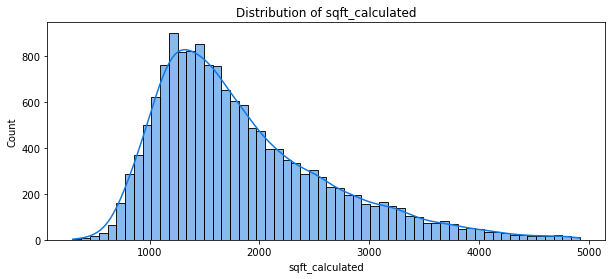

In [28]:
# vizualize sclaed data vs original data
ex.plot_variable_dist(train[['sqft_calculated_mm', 'sqft_calculated']], figsize = (10,4))

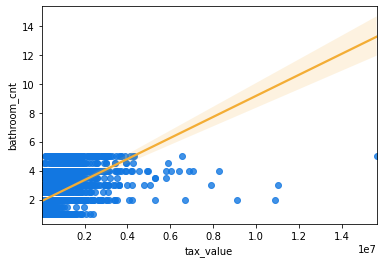

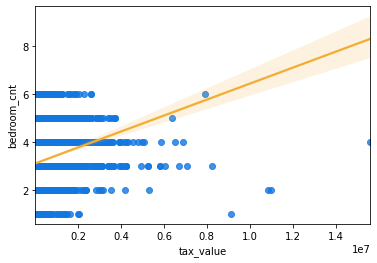

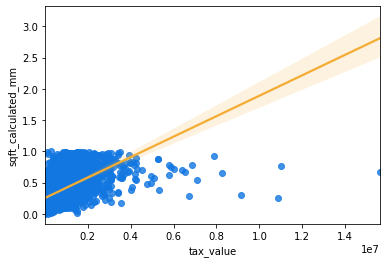

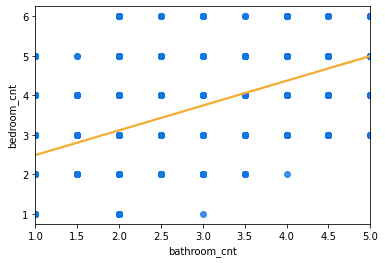

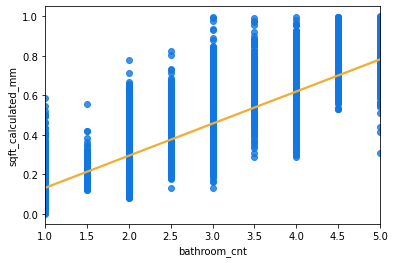

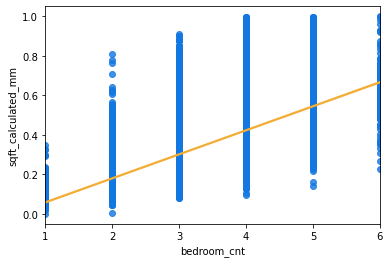

In [27]:
# plot again but scaled
ex.plot_variable_pairs(train, list(train.drop(columns='sqft_calculated')), dot_color='#1277e1', line_color=  '#f3ad35')

<AxesSubplot:>

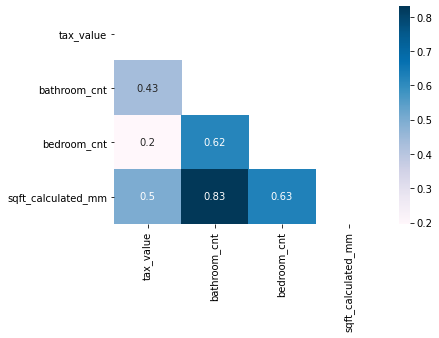

In [42]:
correlation = train.drop(columns='sqft_calculated').corr()
sns.heatmap(correlation, cmap='PuBu', annot = True, mask = np.triu(correlation))

#### Takeaways
- Seems like sqftage and Bathroom count have the highest corelation with tax_value
- but nothing super strong

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Hypothesis Testing

Alpha = 0.05
Confidence interval = 0.95

${H_0}$ There is no linear coorrelation between total square footage and tax value (home value)
${H_a}$ There is a significant linear correlation between total square footage and tax value (home value)

Test: Pearson R

${H_0}$ There is no linear correlation between number of bathrooms and tax value (home value) 
${H_a}$ There is a linear correlation between number of bathrooms and tax value (home value)

(in this case I am considering number of bathroom a continous variable)

Test: Pearson R

In [46]:
# number of samples
n = test.shape[0]
# degrees of freedom
deg_f = n-2
# confidence interval
conf_in = 0.95
alpha = 0.05

n, deg_f, conf_in, alpha

(5483, 5481, 0.95, 0.05)

In [60]:
corr, p = stats.pearsonr(train.sqft_calculated_mm, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4987
p value is 0.0
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


In [61]:
corr, p = stats.pearsonr(train.bathroom_cnt, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4341
p value is 0.0
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Modeling
#### Goals
- Establish and create a basline
    - Evaluate the basline
- Create at least 2 models (GLM) and try to beat the baseline metrics

#### Why GLM?
- The target resembles a gamma distribution
- Will try with power = 2: Gamma Distribution

### Baseline
- mean and median, see which one is better

In [153]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

y_test = test.tax_value
X_test = test[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

In [154]:
# set up baseline and look at rmse
sse, mse, rmse = ev.baseline_mean_errors(y_train)
print(f'RMSE for basline: {rmse}')

RMSE for basline: 517847.1556156348


In [155]:
# put predictions in seperate dataframe
p_train = pd.DataFrame(data = train.tax_value)
p_train['baseline_mean'] = train.tax_value.mean()
p_train['baseline_median'] = train.tax_value.median()

p_validate = pd.DataFrame(data = validate.tax_value)
p_validate['baseline_mean'] = validate.tax_value.mean()
p_validate['baseline_median'] = validate.tax_value.median()

In [156]:
# Put in evaluate.py
# must include import mean_squared_error
def compare_rmse(predictions, actual):
    '''
    This function takes in a list of predictions ex: [df.pred1, df.pred2, df.pred3]
    And the actuals, and prints out the Root Mean Squared Error for each 
    '''
    for prediction in predictions:
        rmse = mean_squared_error(prediction, actual, squared = False)
        print(f'RMSE for {prediction.name}: {rmse} ')

In [157]:
compare_rmse([p_train.baseline_mean, p_train.baseline_median], y_train)

RMSE for baseline_mean: 517847.1556156348 
RMSE for baseline_median: 529876.0897366606 


In [158]:
compare_rmse([p_validate.baseline_mean, p_validate.baseline_median], y_validate)

RMSE for baseline_mean: 507372.93997402873 
RMSE for baseline_median: 519451.8599773961 


#### Takeaways
- baseline mean is slightly better than median, will use mean
- rmse to beat, 518,747.16

### Model 1

In [71]:
def compare_rmse(pred_actuals):
    '''
    This function takes in a list of tuples ex [(df.pred1, df.actuals), (df.pred2, y_validate)]
    And the actuals, and prints out the Root Mean Squared Error for each 
    '''
    for prediction, actual in pred_actuals:
        rmse = mean_squared_error(prediction, actual, squared = False)
        print(f'RMSE for {prediction.name}: {rmse} ')

In [180]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train predictions dataframe
p_train['glm1'] = glm.predict(X_train)

#establish prediction df for validate
p_validate['glm1'] = glm.predict(X_validate)

compare_rmse([(p_train.glm1, y_train), (p_validate.glm1, y_validate)])

RMSE for glm1: 437801.4940931357 
RMSE for glm1: 423090.1024367479 


In [148]:
## Not good. Try again

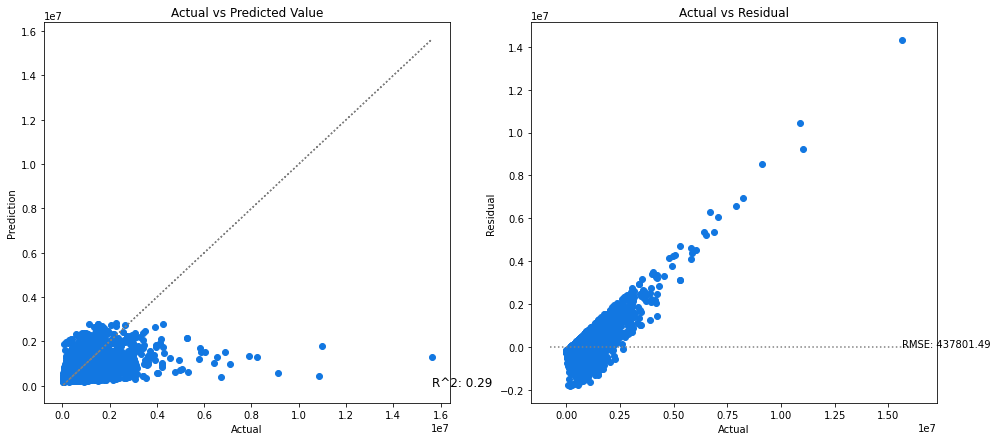

In [181]:
ev.plot_the_dots(y_train, p_train.glm1, y_train - p_train.glm1)

In [186]:
glm = TweedieRegressor(power=1, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train predictions dataframe
p_train['glm2'] = glm.predict(X_train)

#establish prediction df for validate
p_validate['glm2'] = glm.predict(X_validate)

compare_rmse([(p_train.glm2, y_train), (p_validate.glm2, y_validate)])

RMSE for glm2: 436360.85483579006 
RMSE for glm2: 421843.1479689872 


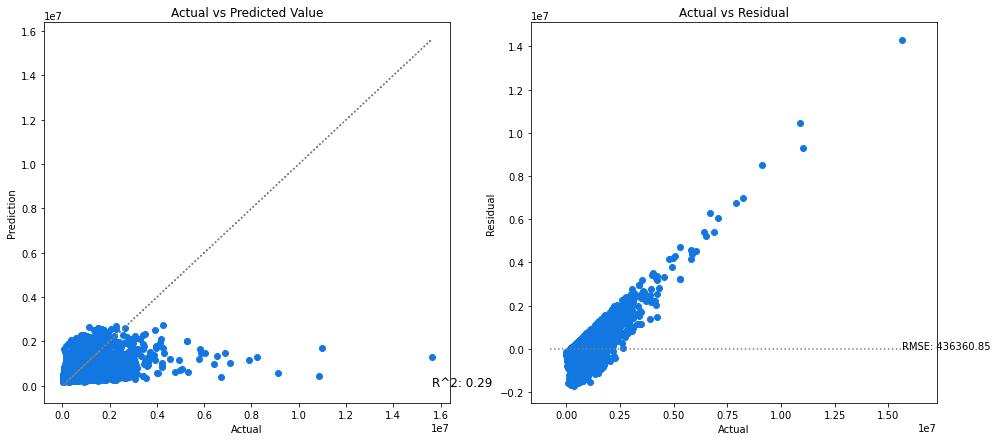

In [187]:
ev.plot_the_dots(y_train, p_train.glm2, y_train - p_train.glm2)

In [168]:
train.head()

,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,sqft_calculated_mm
610,330941.0,3.0,3.0,1496.0,0.259043
16249,378000.0,2.0,3.0,1211.0,0.197314
4575,95200.0,2.0,6.0,1943.0,0.355859
12222,1468483.0,3.0,4.0,3324.0,0.654971
3392,385794.0,1.0,3.0,1204.0,0.195798


In [192]:
lars = LassoLars(alpha=1.0)

#fit model
lars.fit(X_train, y_train)

#put predictions in train predictions dataframe
p_train['lars1'] = lars.predict(X_train)

#establish prediction df for validate
p_validate['lars1'] = lars.predict(X_validate)

compare_rmse([(p_train.lars1, y_train), (p_validate.lars1, y_validate)])

RMSE for lars1: 440453.360144387 
RMSE for lars1: 427991.05147970235 


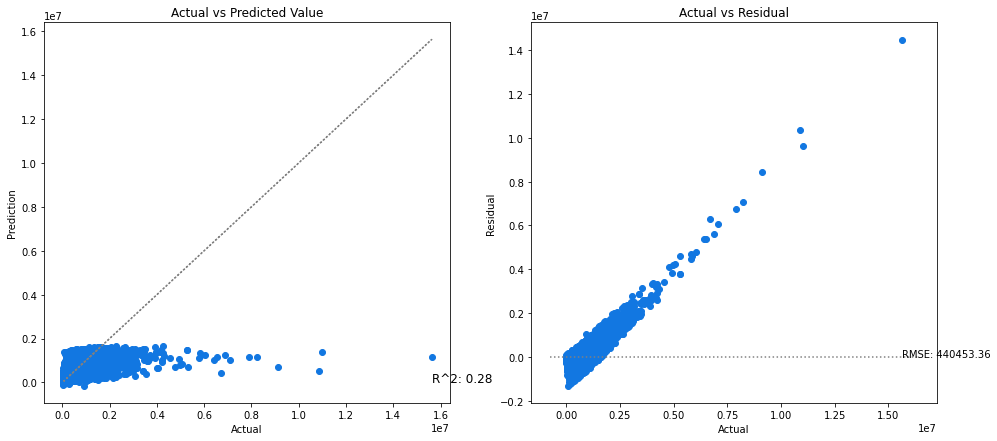

In [193]:
ev.plot_the_dots(y_train, p_train.lars1, y_train - p_train.lars1)

#### Takeaways
- All these models are not good. Back to the scaling process to see if I can deal with outliers in a different way
- maybe bin bathrooms and bedrooms
- On second inspection the models, with some more thought, these models show a 20% improvement over the baseline. So all in all not that bad
- GLM was doing the best though

## Back to the drawing board

In [194]:
df = w.wrangle_zillow()

In [195]:
train, validate, split = w.banana_split(df)

train --> (15349, 8)
validate --> (6579, 8)
test --> (5483, 8)


In [197]:
col_names = ['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated']

MM_scaler, scaled_cols = w.my_scaler(train, validate, test, col_names, MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


In [199]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm']]

y_test = test.tax_value
X_test = test[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm']]

In [211]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train predictions dataframe
p_train['glm3'] = glm.predict(X_train)

#establish prediction df for validate
p_validate['glm3'] = glm.predict(X_validate)

compare_rmse([(p_train.glm3, y_train), (p_validate.glm3, y_validate)])

RMSE for glm3: 437797.9744224706 
RMSE for glm3: 423090.17441009294 


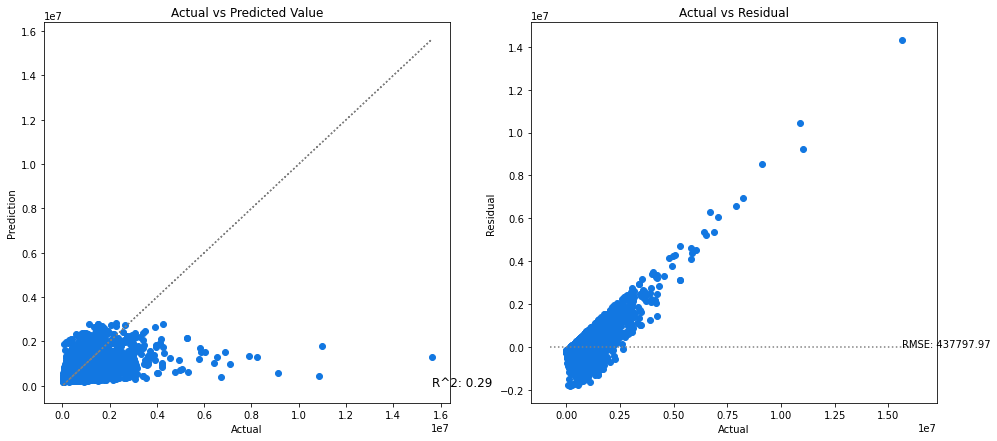

In [212]:
ev.plot_the_dots(y_train, p_train.glm3, y_train - p_train.glm3)

In [213]:
lars = LassoLars(alpha=1.0)

#fit model
lars.fit(X_train, y_train)

#put predictions in train predictions dataframe
p_train['lars2'] = lars.predict(X_train)

#establish prediction df for validate
p_validate['lars2'] = lars.predict(X_validate)

compare_rmse([(p_train.lars2, y_train), (p_validate.lars2, y_validate)])

RMSE for lars2: 440453.360144387 
RMSE for lars2: 427991.0514797024 


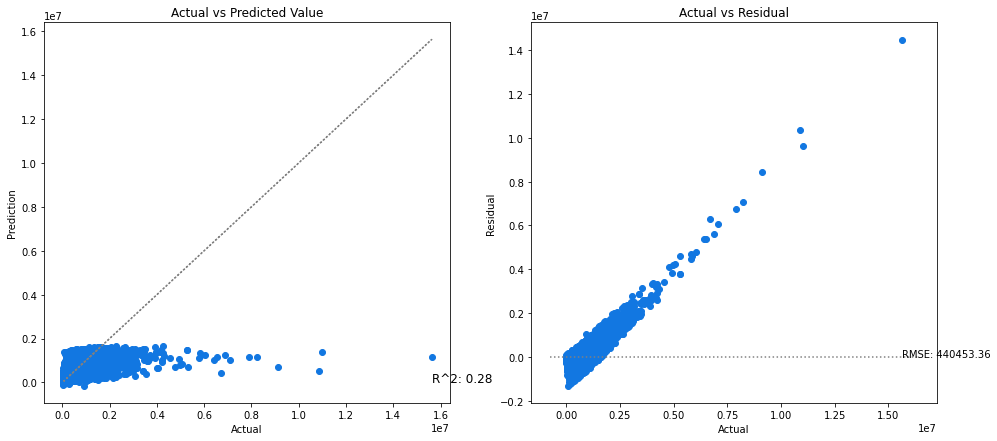

In [214]:
ev.plot_the_dots(y_train, p_train.lars2, y_train - p_train.lars2)

### Takeaways
- These are still bad
- I'm going to add some features
    - age
    - pool
    - garage


In [6]:
df = w.get_zillow_data()

In [7]:
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,garage_car_count,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,NaN,NaN,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,1.0,NaN,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,NaN,NaN,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,NaN,2.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,NaN,NaN,6037.0,1399.27,2017-08-23


In [11]:
# fill nans with 0s
# add to function
df['has_pool'] = df.has_pool.fillna(value=0)

In [13]:
# fill nas with 0s for garage
df.garage_car_count.fillna(value=0, inplace=True)

In [28]:
# add new column has garage as boolian. anything over 1 is having a garage, 0 no garage
# ad to function
df['has_garage'] = (df.garage_car_count != 0).astype(int)

### Get data again after adding new columns

In [4]:
df = w.wrangle_zillow()

In [5]:
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,has_garage
0,11721753,205123.0,2.0,3.0,1316.0,0.0,6037.0,2627.48,2017-07-21,0
1,11289917,136104.0,2.0,3.0,1458.0,1.0,6037.0,2319.90,2017-06-23,0
2,11705026,35606.0,1.0,2.0,1421.0,0.0,6037.0,543.69,2017-06-30,0
3,14269464,880456.0,3.0,4.0,2541.0,0.0,6059.0,9819.72,2017-06-01,1
4,11446756,107110.0,2.0,3.0,1491.0,0.0,6037.0,1399.27,2017-08-23,0


In [6]:
train, validate, test = w.banana_split(df)

train --> (15349, 10)
validate --> (6579, 10)
test --> (5483, 10)


#### Explore with new categories

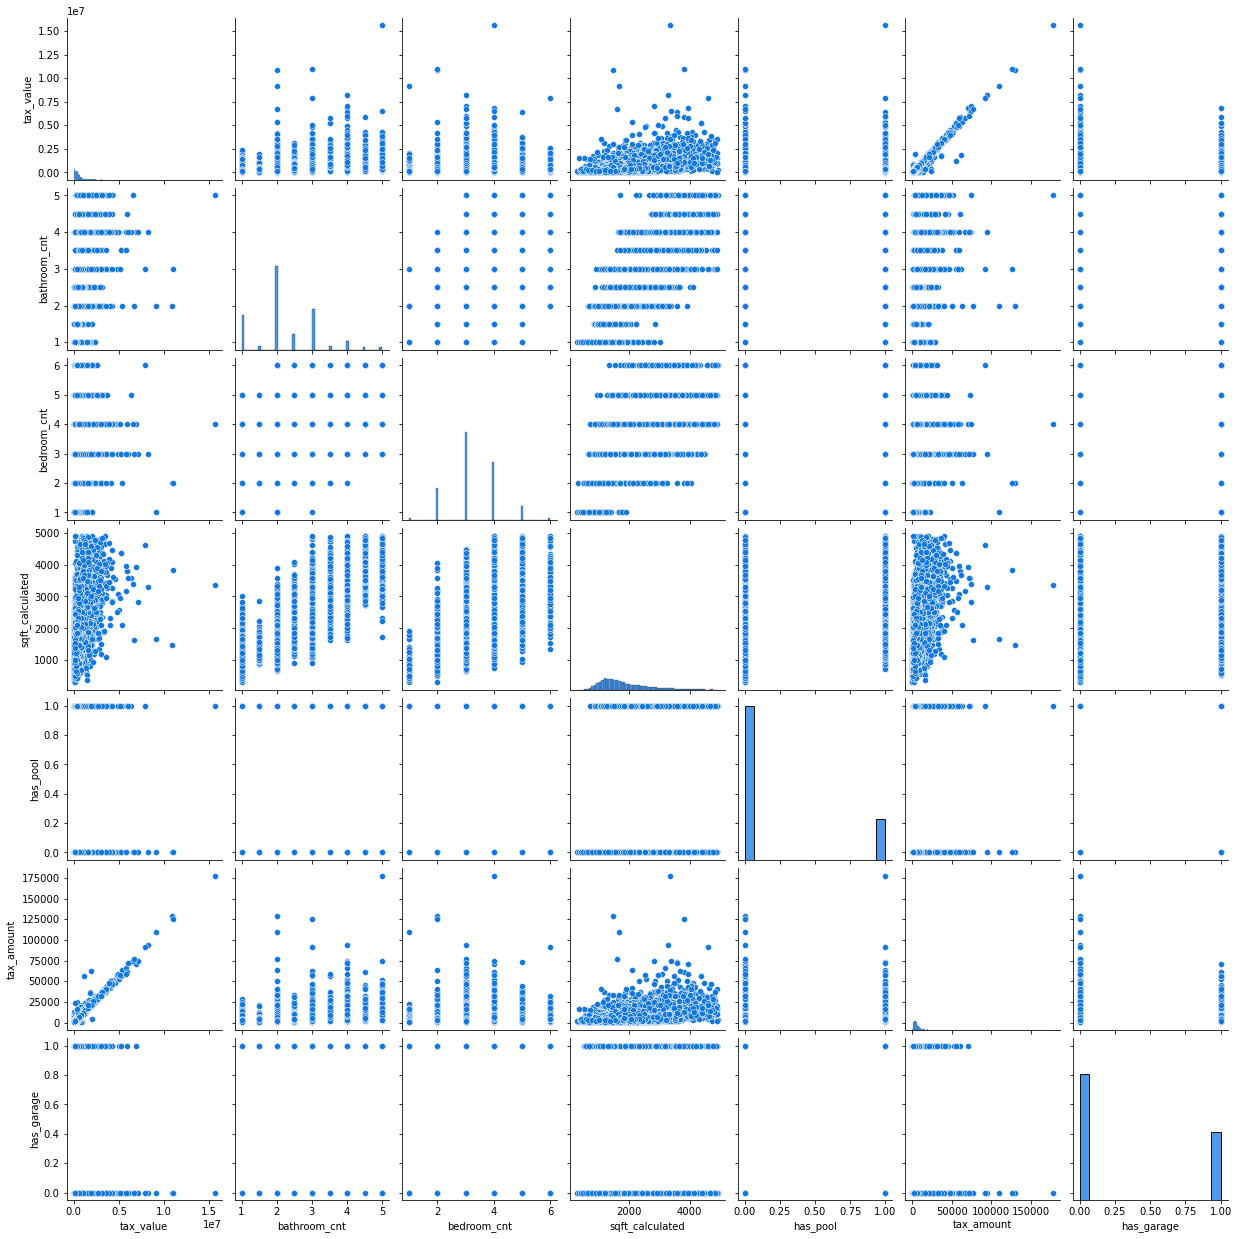

In [9]:
sns.pairplot(train.drop(columns=['fips', 'parcel_id']))

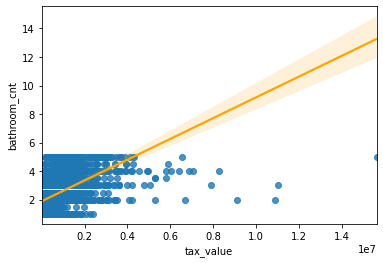

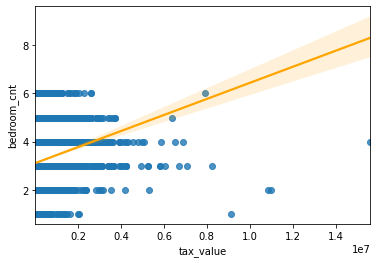

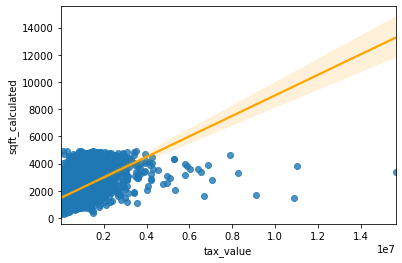

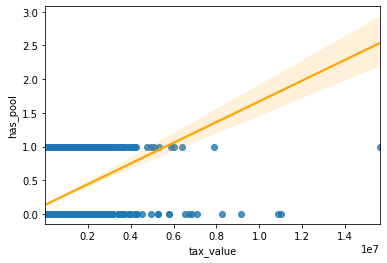

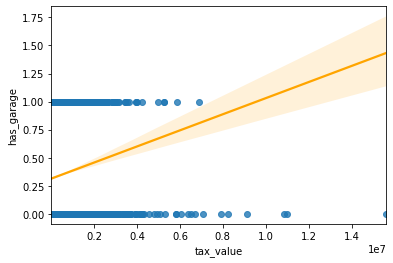

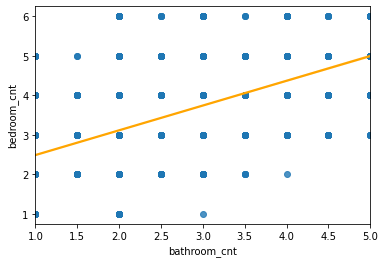

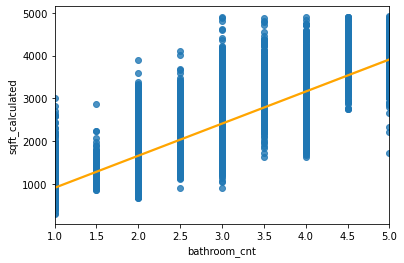

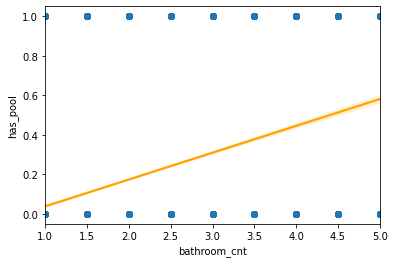

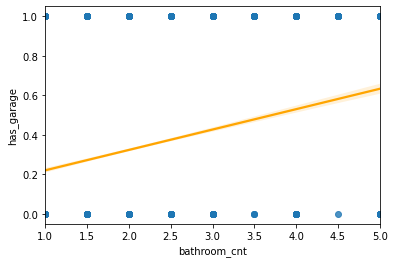

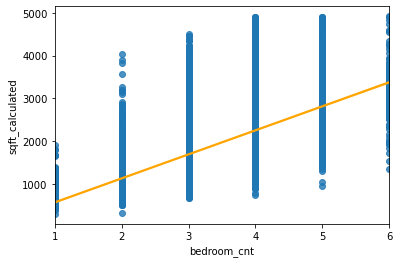

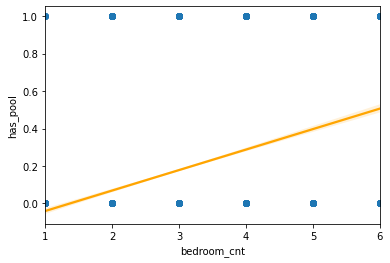

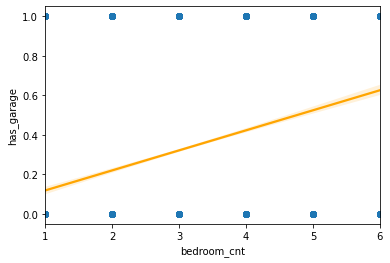

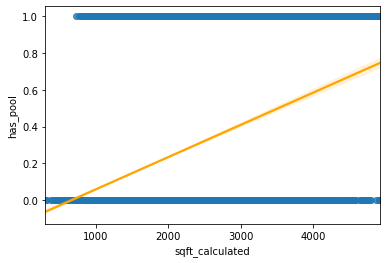

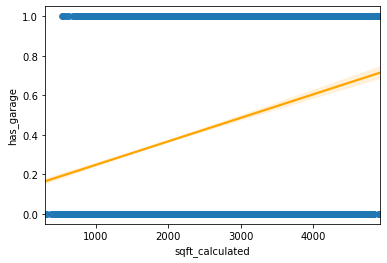

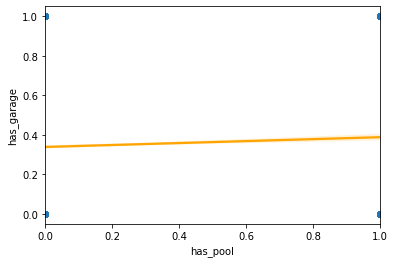

In [13]:
ex.plot_variable_pairs(train,  ['tax_value', 'bathroom_cnt', 'bedroom_cnt',
       'sqft_calculated', 'has_pool',
       'has_garage'])

In [14]:
col_names = ['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated']

MM_scaler, scaled_cols = w.my_scaler(train, validate, test, col_names, MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


In [54]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

y_test = test.tax_value
X_test = test[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

In [22]:
ev.select_kbest(X_train, y_train, 3)

['bathroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']

In [28]:
ev.rfe(X_train, y_train, 4)

['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']

## Try modeling a third time

In [55]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train predictions dataframe
train['glm4'] = glm.predict(X_train)

#establish prediction df for validate
validate['glm4'] = glm.predict(X_validate)

compare_rmse([(train.glm4, y_train), (validate.glm4, y_validate)])

RMSE for glm4: 437416.92686737183 
RMSE for glm4: 422590.8926269492 


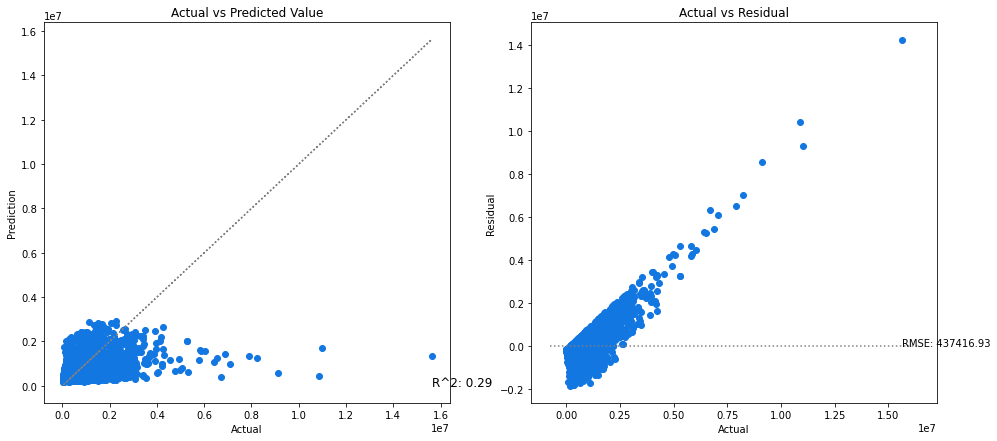

In [56]:
ev.plot_the_dots(y_train, train.glm4, y_train - train.glm4)

In [70]:
lars = LassoLars(alpha=-1.0, fit_intercept=True)

#fit model
lars.fit(X_train, y_train)

#put predictions in train predictions dataframe
train['lars3'] = lars.predict(X_train)

#establish prediction df for validate
validate['lars3'] = lars.predict(X_validate)

compare_rmse([(train.lars3, y_train), (validate.lars3, y_validate)])

RMSE for lars3: 440117.05775364547 
RMSE for lars3: 427677.07339716295 


## County and Tax Rates
#### Goals
- switch fips to county names
- calculate tax rate (tax amt/tax value)
- vizualize (or export into tableau)

In [61]:
# get data that the outliers haven't been removed yet
df = w.get_zillow_data()

In [62]:
# make dictionary with fips values and county names
counties = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}

# use .replace to create an new column called county
df['county'] = df.fips.replace(counties)

In [66]:
# create new column with tax_rate
df['tax_rate'] = df.tax_amount / df.tax_value

In [72]:
train

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,has_garage,bathroom_cnt_mm,bedroom_cnt_mm,sqft_calculated_mm,glm4,lars3
610,13091563,330941.0,3.0,3.0,1496.0,0.0,6037.0,4426.94,2017-05-02,0,0.50,0.4,0.259043,411061.844562,450506.320084
16249,12992863,378000.0,2.0,3.0,1211.0,0.0,6037.0,4937.03,2017-07-07,0,0.25,0.4,0.197314,306524.317920,275378.008438
4575,11394195,95200.0,2.0,6.0,1943.0,0.0,6037.0,1281.42,2017-05-19,0,0.25,1.0,0.355859,262344.030822,140383.107847
12222,13926565,1468483.0,3.0,4.0,3324.0,1.0,6059.0,16427.46,2017-06-22,1,0.50,0.6,0.654971,988304.400162,987725.812018
3392,10876631,385794.0,1.0,3.0,1204.0,0.0,6037.0,10428.83,2017-05-16,0,0.00,0.4,0.195798,264904.562221,194514.210193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,10721619,535000.0,2.0,4.0,1490.0,0.0,6037.0,6603.88,2017-06-29,0,0.25,0.6,0.257743,296482.894110,242247.542662
4005,12290192,132732.0,1.0,2.0,1014.0,0.0,6037.0,2602.31,2017-05-18,0,0.00,0.2,0.154646,287121.229255,257822.883497
17842,11281993,159887.0,2.0,3.0,1543.0,0.0,6037.0,2755.00,2017-07-14,0,0.25,0.4,0.269222,365574.830636,387952.894945
25813,14050123,110555.0,2.0,3.0,1390.0,0.0,6059.0,1472.56,2017-08-23,1,0.25,0.4,0.236084,337067.234273,336073.504477
